In [1]:
from quadmodel.inference.forward_model import forward_model
import os
import numpy as np
import matplotlib.pyplot as plt

### Forward modeling image flux ratios with quadmodel

In the following cell, we define the parameters we want to sample in the forward model, and set the lens data class

In [6]:
output_path = os.getcwd() + '/example_inference_output/'
job_index = 1
n_keep = 10
summary_statistic_tolerance = 0.1
lens_data = 'B1422'
from quadmodel.data.b1422 import B1422
lens_data = B1422()
print(lens_data.m)
realization_priors = {}
realization_priors['PRESET_MODEL'] = 'ULDM'
realization_priors['sigma_sub'] = ['FIXED', 0.05]
realization_priors['LOS_normalization'] = ['FIXED', 1.0]
realization_priors['power_law_index'] = ['FIXED', -1.9]
realization_priors['log_m_host'] = ['FIXED', 13.3]
realization_priors['log10_m_uldm'] = ['UNIFORM', -20.3, -20.4]


[0.88  1.    0.474 0.025]


### Run the simulation

reading output to files: 
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
starting with 2 samples accepted, 8 remain
existing magnifications:  [[1.       0.84308  0.310325 0.047081]
 [0.694737 1.       0.576582 0.025849]]
samples remaining:  8
realization contains 10263 halos.
realization parameter array:  -20.38391920378203
optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  2
N subhalos:  7
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
PSO done... 
source plane chi^2:  78808.01186598108
total chi^2:  78808.01186598108
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.39301464, -0.39301438, -0.39301456, -0.39301451]), array([0.28199267, 0.28199246, 0.28199256, 0.28199263]))
optimization 2
aperture size

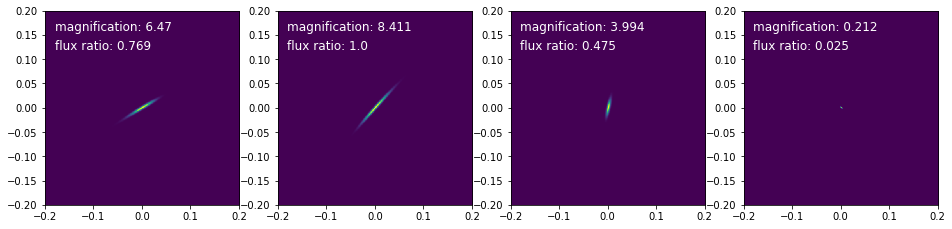

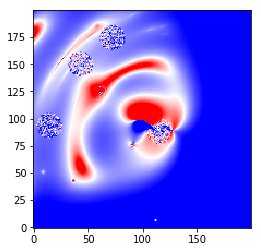

continue
flux ratios data:  [1.1363636363636365, 0.5386363636363636]
flux ratios model:  [1.2767317271332246, 0.6187274462229863]
statistic:  0.16160997003958805
accepeted realizations counter:  1
readout steps:  2
realization contains 15058 halos.
realization parameter array:  -20.30046547417434
optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  0
N subhalos:  10
10
20
30
40
50
60
70
80
PSO done... 
source plane chi^2:  73194.6615745061
total chi^2:  73194.6615745061
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.39723691, -0.39723692, -0.39723679, -0.39723679]), array([0.27174196, 0.27174216, 0.27174198, 0.27174204]))
optimization 2
aperture size:  0.3
minimum mass in aperture:  1.0
minimum global mass:  7.0
N foreground halos:  0
N subhalos:  14838


KeyboardInterrupt: 

In [7]:
forward_model(output_path, job_index, lens_data, n_keep, realization_priors, tolerance=summary_statistic_tolerance,
                  verbose=True, ray_tracing_optimization='uldm', test_mode=True)

### Examine the output

The simulation output includes files named fluxes.txt, parameters.txt, and simulation_output_1, simulation_output_2, etc.

In [ ]:
f = open(output_path + 'job_'+str(job_index)+'/parameters.txt', 'r')
param_names = f.readlines()[0]
print('PARAMETER NAMES:')
print(param_names)
f.close()

accepeted_parameters = np.loadtxt(output_path + 'job_'+str(job_index)+'/parameters.txt', skiprows=1)
print('ACCEPTED PARAMETERS:')
print(accepeted_parameters)
# the first set of parameters are the ones specified in kwargs_realization (see cell #2), the rest are the source size, 
# macromodel parameters, and the last parameter is the summary statistic

accepeted_mags = np.loadtxt(output_path + 'job_'+str(job_index)+'/fluxes.txt')
print('\nACCEPTED MAGNIFICATIONS:')
print(accepeted_mags)

### Visualize accepeted realizations

The pickeled classes in simulation_output allow you to visualize the accepeted realizations

In [ ]:
import pickle
f = open(output_path + 'job_'+str(job_index)+'/simulation_output_1', 'rb')
simulation_output = pickle.load(f)
x_image, y_image = simulation_output.data.x, simulation_output.data.y
lens_system = simulation_output.lens_system

npix = 150
rminmax = 1.25
_r = np.linspace(-rminmax, rminmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
lensmodel, kwargs_lens = lens_system.get_lensmodel()
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)

kappa = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

In [ ]:
import matplotlib.pyplot as plt

vminmax = 0.1
kappa_subs_nonlinear = kappa - kappa_macro
extent = [-rminmax, rminmax, -rminmax, rminmax]

fig = plt.figure(1)
fig.set_size_inches(8, 8)
plt.imshow(kappa_subs_nonlinear, vmin=-vminmax, vmax=vminmax, origin='lower', cmap='bwr', 
           extent=extent)
plt.scatter(x_image, y_image, color='k')
plt.show()

source_size_pc = accepeted_parameters[0, 4]
lens_system.plot_images(x_image, y_image, source_size_pc, lensmodel, kwargs_lens)

Using the plot_images routine in lens_system, you can also ray trace through the lens system to see what the images look like (or how they would look with an ridiculously large telescope and no PSF) 